#BackProp

In [9]:
import os
from PIL import Image
import numpy as np
import pylab as pl
from scipy import misc
import re
%pylab inline

from nn.MLP import MLP as MLP1
from nn.Distances import d_log_Bernoulli_likelihood, log_Bernoulli_likelihood, xeuclidian, d_xeuclidian 

Populating the interactive namespace from numpy and matplotlib


In [10]:
DATA_PATH = "../DataSets/big_alphabet_29x29/"


In [22]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def d_sigmoid(z):
    s = sigmoid(z)
    return s * (1 - s)


def l2dist(y, pred):
    return np.sum((pred - y)**2, axis=1).reshape(pred.shape[0], 1)


def d_l2dist(y, pred):
    return 2 * (pred - y)


def softmax(z):
    ex = np.exp(z)
    return ex / np.sum(ex, axis=1).reshape(ex.shape[0], 1)


def d_softmax(m):
    y = softmax(m)
    return y * (1 - y)

def idx(m):
    return m

def d_idx(m):
    return 1

In [68]:
class MLP:
    def __init__(self, input_dimension=None,
                 layers=None,
                 f_activation=None,
                 df_activation=None,
                 n_steps=200,
                 seed=179,
                 regularization='L2',
                 learning_rate=0.1,
                 verbose=True):
        np.random.seed(seed)
        
        if input_dimension is None:
            raise ValueError("Input dimension must not be None")

        if layers is None:
            self.n_layers = 10
            layers = [self.n_layers for _ in range(self.n_layers)]
        self.n_layers = len(layers)

        if f_activation is None or df_activation is None:
            f_activation = [sigmoid for _ in range(self.n_layers)]
            df_activation = [d_sigmoid for _ in range(self.n_layers)]

        self.w = [None] * self.n_layers
        for i in range(0, self.n_layers):
            prev = (layers[i - 1] if i != 0 else input_dimension)
            nxt = layers[i]
            self.w[i] = np.random.uniform(-1, 1, (prev + 1, nxt))
        
        self.verbose = verbose
        self.layers = layers
        self.f_activation = f_activation
        self.df_activation = df_activation

        self.loss = l2dist
        self.d_loss = d_l2dist
        self.n_steps = n_steps
        self.regularization = regularization

        self.learning_rate = learning_rate

    def fit(self, X, Y, val_x, val_y, add_bias=True):
        if add_bias:
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis=1)

        err_tr = list()
        err_val = list()
        Xs = [None] * self.n_layers
        fXs = [None] * self.n_layers

        for t in range(self.n_steps):
            tmp = X
            for i in range(self.n_layers):
                Xs[i] = np.dot(tmp, self.w[i])
                tmp = self.f_activation[i](Xs[i])
                fXs[i] = tmp
                if i != self.n_layers - 1:
                    tmp = np.concatenate((tmp, np.ones(tmp.shape[0]).reshape(tmp.shape[0], 1)), axis=1)

            err_tr.append(self.loss(Y, fXs[-1]).mean())
            err_val.append(self.loss(val_y, self.predict(val_x)).mean())

            gradW = [None] * self.n_layers
            dE_n = None
            for i in reversed(range(self.n_layers)):
                dE = None
                if i == self.n_layers - 1:
                    dE = self.d_loss(Y, fXs[i]) * self.df_activation[i](Xs[i])
                    dE_n = dE
                else:
                    dE = np.dot(self.w[i + 1][:-1, :], dE_n.T).T * self.df_activation[i](Xs[i])
                    dE_n = dE
                
                inp = None
                if i == 0:
                    inp = X
                else:
                    inp = np.concatenate((fXs[i - 1], np.ones(fXs[i - 1].shape[0]).reshape(fXs[i - 1].shape[0], 1)), axis=1)

                gradW[i] = np.dot(inp.T, dE) / len(X)
                self.gradW = gradW
                
            for i in range(self.n_layers):
                #if self.regularization == 'L2':
                #    gradW[i] += 2*self.w[i]
                self.w[i] -= self.learning_rate * gradW[i]
            
            if self.verbose:
                print "Iteration {0}, cv error={1}, train error={2}".fit(err_val[-1], err_tr[-1])

        return err_tr, err_val

    def predict(self, X, add_bias=True):
        if add_bias:
            X = np.concatenate((X, np.ones(X.shape[0]).reshape(X.shape[0], 1)), axis=1)

        tmp = np.copy(X)
        #print tmp
        for i in range(0, self.n_layers):
            tmp = np.dot(tmp, self.w[i])
            tmp = self.f_activation[i](tmp)
            #print tmp
            if i != self.n_layers - 1:
                tmp = np.concatenate((tmp, np.ones(tmp.shape[0]).reshape(tmp.shape[0], 1)), axis=1)

        return tmp

In [69]:
data = list()
target = list()
classes = list()

train_data_1 = list()
train_target_1 = list()
train_class_1 = list()

data_n = np.empty((0, 29*29))
target_n = np.empty((0, 26))
for pt in os.listdir(DATA_PATH):
    im = misc.imread(os.path.join(DATA_PATH, pt), flatten=True).flatten() / 255.0
                       
    data.append(im)
    
    parts = re.split('[-\.]', pt)
    
    c_class = int(pt[:-4].split("-")[1])
    c_target = np.zeros(26)
    c_target[c_class] = 1.0
    target.append(c_target)
    classes.append(c_class)
    
    if "mutant" not in parts or parts[2] not in ["5", "6", "7", "8"]:
        train_data_1.append(im)
        train_target_1.append(c_target)
        train_class_1.append(c_class)
    
data = np.array(data)
target = np.array(target)
classes = np.array(classes)

train_data_1 = np.array(train_data_1)
train_target_1 = np.array(train_target_1)
train_class_1 = np.array(train_class_1)



In [70]:
print train_data_1.shape, train_input.shape
print (train_data_1 == train_input).all()
print (train_target_1 == train_output).all()

(156, 841) (156, 841)
True
True


In [43]:
train_idx = np.random.randint(0, 5, size=data.shape[0])

train_data = data[train_idx != 0, ::] 
train_target = target[train_idx != 0, ::]
train_classes = classes[train_idx != 0]

val_data = data[train_idx == 0, ::] 
val_target = target[train_idx == 0, ::]
val_classes = classes[train_idx == 0]


In [44]:
print val_data.shape
print val_target.shape

(44, 841)
(44, 26)


In [64]:
mlp = MLP(input_dimension=29*29, 
          layers=[100 for i in range(1)] + [26], 
          f_activation=[sigmoid, sigmoid], 
          df_activation=[d_sigmoid, d_sigmoid],
          n_steps=2000,
          learning_rate=0.01)

In [65]:
errors_train, errors_val = mlp.fit(train_data, train_target, val_data, val_target)

11.233081063


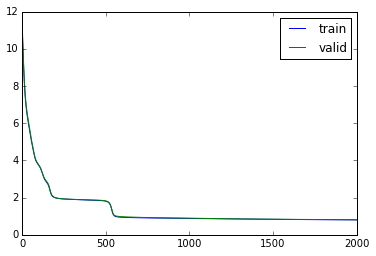

In [72]:
print errors_train[0]
pl.plot(errors_train, label="train")
pl.plot(errors_val, label="valid")
pl.legend()
pl.show()

In [73]:
val_prediction = mlp.predict(val_data)
val_ans = np.argmax(pr, axis=1)

train_prediction = mlp.predict(train_data)
train_ans = np.argmax(train_prediction, axis=1)

print "Train accuracy %d/%d" % ((train_ans == train_classes).sum(), train_classes.size) 
print "Validation accuracy %d/%d" % ((val_ans == val_classes).sum(), ans.size) 

Train accuracy 81/216
Validation accuracy 29/44


In [38]:
mlp1 = MLP1(input_dimension=29*29, 
          layers_structure=[100 for i in range(1)] + [26], 
           activation_functions=[sigmoid, sigmoid])

error = mlp1.train_backprop(train_data, 
                    train_target, 
                    learning_rate=0.1,
                    goal=l2dist, 
                    d_goal=d_l2dist,
                    d_f_list=[d_sigmoid, d_sigmoid], 
                    max_iter=1000)

Iteration: 0 (0.014749 s), train cost = 2.77976790633
Iteration: 1 (0.013851 s), train cost = 1.64321982917
Iteration: 2 (0.013325 s), train cost = 1.32787144596
Iteration: 3 (0.013305 s), train cost = 1.19976154565
Iteration: 4 (0.013257 s), train cost = 1.13184863781
Iteration: 5 (0.013897 s), train cost = 1.09017686081
Iteration: 6 (0.014015 s), train cost = 1.06228815491
Iteration: 7 (0.013413 s), train cost = 1.04251336313
Iteration: 8 (0.013539 s), train cost = 1.0278920728
Iteration: 9 (0.013711 s), train cost = 1.01672859322
Iteration: 10 (0.01327 s), train cost = 1.00798461179
Iteration: 11 (0.012882 s), train cost = 1.00099110866
Iteration: 12 (0.012916 s), train cost = 0.995299190897
Iteration: 13 (0.011813 s), train cost = 0.990597499772
Iteration: 14 (0.012733 s), train cost = 0.986663978899
Iteration: 15 (0.013334 s), train cost = 0.983336456346
Iteration: 16 (0.013064 s), train cost = 0.980494037689
Iteration: 17 (0.013255 s), train cost = 0.978044966638
Iteration: 18 (0

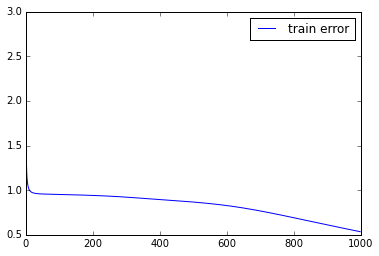

In [39]:
pl.plot(error, label="train error")
pl.legend()
pl.show()


In [309]:
prediction = mlp1.compute_output(val_data)
prediction_classes = np.argmax(prediction, axis=1)

print "accuracy: %d of %d" % (np.sum(prediction_classes == val_classes), val_classes.size)

accuracy: 101 of 145


In [15]:
import numpy as np
from nn.MLP import MLP, sigmoid, d_sigmoid, d_identity, identity, tanh, d_tanh
from nn.MLP import xeuclidian, d_xeuclidian, log_Bernoulli_likelihood, d_log_Bernoulli_likelihood
from nn.Norms import l2, d_l2
from scipy import misc
import os
import re

if __name__ == '__main__':


    train_input = np.empty((0, 841))
    cv_input = np.empty((0, 841))
    test_input = np.empty((0, 841))
    train_output = np.empty((0, 26))
    cv_output = np.empty((0, 26))
    test_output = np.empty((0, 26))

    for f in os.listdir(DATA_PATH):
        v = np.array(misc.imread(DATA_PATH + f, flatten=True)).flatten() / 255.0
        parts = re.split('[-\.]', f)
        i = int(parts[1])
        o = np.zeros(26)
        o[i] = 1.0
        if len(parts) == 5 and parts[2] in ['7', '8']:
            cv_input = np.vstack([cv_input, v])
            cv_output = np.vstack([cv_output, o])
        elif len(parts) == 5 and parts[2] in ['5', '6']:
            test_input = np.vstack([test_input, v])
            test_output = np.vstack([test_output, o])
        else:
            train_input = np.vstack([train_input, v])
            train_output = np.vstack([train_output, o])


    nn = MLP(841, (100, 26),
                       activation_functions=[sigmoid, sigmoid],
                       rng=(lambda n: np.random.normal(0, 0.01, n)))
    train_cost = \
        nn.train_backprop(train_input, train_output,
                          d_f_list=[d_sigmoid, d_sigmoid],
                          goal=log_Bernoulli_likelihood,
                          d_goal=d_log_Bernoulli_likelihood,
                          #batch_size=None,
                          max_iter=1000,
                          learning_rate=0.1
                          #momentum_rate=0.9,
                          #neural_local_gain=(0.005, 0.995, 0.001, 1000),
                          #stop_threshold=0.05,
                          #cv_input_data=cv_input,
                          #cv_output_data=cv_output,
                          #regularization_rate=0.1,
                          #regularization_norm=l2,
                          #d_regularization_norm=d_l2
                          #verbose=True
                          )

    t = np.argmax(train_output, axis=1)
    y = np.argmax(nn.compute_output(train_input), axis=1)

    print('%s / %s' % (sum(t == y), train_output.shape[0]))

    t = np.argmax(test_output, axis=1)
    y = np.argmax(nn.compute_output(test_input), axis=1)

    print('%s / %s' % (sum(t == y), test_output.shape[0]))

 Iteration: 0 (0.020097 s), train cost = 8.02392831095
Iteration: 1 (0.019996 s), train cost = 4.25904039285
Iteration: 2 (0.019151 s), train cost = 4.23935533505
Iteration: 3 (0.018965 s), train cost = 4.23955579168
Iteration: 4 (0.019339 s), train cost = 4.23896475741
Iteration: 5 (0.02285 s), train cost = 4.23865437201
Iteration: 6 (0.019713 s), train cost = 4.23851071723
Iteration: 7 (0.019213 s), train cost = 4.23842729701
Iteration: 8 (0.022093 s), train cost = 4.23836331584
Iteration: 9 (0.018945 s), train cost = 4.23830537503
Iteration: 10 (0.023605 s), train cost = 4.23824926064
Iteration: 11 (0.022429 s), train cost = 4.23819365701
Iteration: 12 (0.018694 s), train cost = 4.23813814575
Iteration: 13 (0.018705 s), train cost = 4.23808258519
Iteration: 14 (0.018448 s), train cost = 4.2380269193
Iteration: 15 (0.022888 s), train cost = 4.23797111883
Iteration: 16 (0.018503 s), train cost = 4.237915163
Iteration: 17 (0.020812 s), train cost = 4.2378590337
Iteration: 18 (0.023655 

In [19]:
nn = MLP(841, (100, 26),
                   activation_functions=[sigmoid, sigmoid],
                   rng=(lambda n: np.random.normal(0, 0.01, n)))
train_cost = \
    nn.train_backprop(train_data, train_target,
                      d_f_list=[d_sigmoid, d_sigmoid],
                      goal=log_Bernoulli_likelihood,
                      d_goal=d_log_Bernoulli_likelihood,
                      #batch_size=None,
                      max_iter=1000,
                      learning_rate=0.1
                      #momentum_rate=0.9,
                      #neural_local_gain=(0.005, 0.995, 0.001, 1000),
                      #stop_threshold=0.05,
                      #cv_input_data=cv_input,
                      #cv_output_data=cv_output,
                      #regularization_rate=0.1,
                      #regularization_norm=l2,
                      #d_regularization_norm=d_l2
                      #verbose=True
                      )

t = np.argmax(train_output, axis=1)
y = np.argmax(nn.compute_output(train_input), axis=1)

print('%s / %s' % (sum(t == y), train_output.shape[0]))

t = np.argmax(test_output, axis=1)
y = np.argmax(nn.compute_output(test_input), axis=1)

print('%s / %s' % (sum(t == y), test_output.shape[0]))

Iteration: 0 (0.030609 s), train cost = 7.90633317437
Iteration: 1 (0.029881 s), train cost = 4.25377492174
Iteration: 2 (0.028356 s), train cost = 4.22904312053
Iteration: 3 (0.028519 s), train cost = 4.22714186505
Iteration: 4 (0.031622 s), train cost = 4.22564311764
Iteration: 5 (0.025289 s), train cost = 4.22491250391
Iteration: 6 (0.026343 s), train cost = 4.22456094645
Iteration: 7 (0.030012 s), train cost = 4.22436817751
Iteration: 8 (0.026956 s), train cost = 4.224244404
Iteration: 9 (0.027063 s), train cost = 4.22415344457
Iteration: 10 (0.030257 s), train cost = 4.22407952787
Iteration: 11 (0.029026 s), train cost = 4.22401504849
Iteration: 12 (0.026624 s), train cost = 4.22395600051
Iteration: 13 (0.029892 s), train cost = 4.22390013541
Iteration: 14 (0.025881 s), train cost = 4.22384613677
Iteration: 15 (0.02609 s), train cost = 4.22379321192
Iteration: 16 (0.031868 s), train cost = 4.2237408735
Iteration: 17 (0.027039 s), train cost = 4.22368881635
Iteration: 18 (0.025867 

In [ ]:
eps = 1e-4
nGradW = [None]*len(mlp.w)
for t in range(len(mlp.w)):
    nGradW[t] = np.zeros(mlp.w[t].shape[0] * mlp.w[t].shape[1]).reshape(mlp.w[t].shape[0], mlp.w[t].shape[1])
    for i in range(mlp.w[t].shape[0]):
        for j in range(mlp.w[t].shape[1]):    
            res_train = mlp.predict(train_data)
            mlp.w[t][i][j] += eps
            res_train_new = mlp.predict(train_data)
            mlp.w[t][i][j] -= eps            
            ls1 = mlp.loss(res_train, train_target)
            ls2 = mlp.loss(res_train_new, train_target)
            nGradW[t][i][j] = ((ls1 - ls2) / eps).mean()